# 3.1 Using Pretrained Word Embeddings to Find Word Similarity 
  
Problem: You need to find out whether two words are similar but not equal.  
  
Solution: Use a pretrained word embedding model. In the code example we use `genism`, a Python library for topic modeling.  

First step is to aquire a pretrained model, here we use Google News. 

In [1]:
%matplotlib inline

import os
from keras.utils import get_file
import gensim
import subprocess
import numpy as np
import matplotlib.pyplot as plt
from IPython.core.pylabtools import figsize
figsize(10, 10)

from sklearn.manifold import TSNE
import json
from collections import Counter
from itertools import chain

/Users/nikkibytes/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
MODEL = 'GoogleNews-vectors-negative300.bin'
path = get_file(MODEL + '.gz', 'https://deeplearning4jblob.blob.core.windows.net/resources/wordvectors/%s.gz' % MODEL)
if not os.path.isdir('generated'):
    os.mkdir('generated')

unzipped = os.path.join('generated', MODEL)
if not os.path.isfile(unzipped):
    with open(unzipped, 'wb') as fout:
        zcat = subprocess.Popen(['zcat'],
                          stdin=open(path),
                          stdout=fout
                         )
        zcat.wait()

In [3]:
model = gensim.models.KeyedVectors.load_word2vec_format(unzipped, binary=True)

Once model has finished loading we can use it to find similar words:

In [4]:
model.most_similar(positive=['espresso'])

[('cappuccino', 0.6888186931610107),
 ('mocha', 0.6686208844184875),
 ('coffee', 0.6616826057434082),
 ('latte', 0.6536753177642822),
 ('caramel_macchiato', 0.6491268873214722),
 ('ristretto', 0.6485545635223389),
 ('espressos', 0.6438628435134888),
 ('macchiato', 0.6428250074386597),
 ('chai_latte', 0.6308028697967529),
 ('espresso_cappuccino', 0.6280542612075806)]

##### Discussion: Word embeddings associate an n-dimensional vector with each word in the vocabulary in a way that similar words are near each other. Finding similar words is a mere **nearest-neighbor** search. The Word2vec embeddings are obtained by training a NN to predict a word from its context. Words that can be inserted into similar patterns will get vectors that are close to each other. Here we don't care about the actual task, just about the assigned weights, which we get as a side effect of training the network.  
  
Note later we will see how word embeddings can also be used to feed words into a neural network. It is much more feasible to feed a 300-dim embedding vector into a network than a 3-million-dim one that is one-hot encoded. Moreover, a network fed with pretrained word embeddings doesn't have to learn the relationships between the wrods, but can start with the real task at hand immediately. 

# 3.2 Word2vec Math  

#### Problem: How can you automatically answer questions of the form "A is to B as C is to what?"  
  
#### Solution: Use the semantic properties of the Word2vec model. The `gensim` library makes this straightforward:

In [5]:
def A_is_to_B_as_C_is_to(a, b, c, topn=1):
    a, b, c = map(lambda x:x if type(x) == list else [x], (a, b, c))
    res = model.most_similar(positive=b + c, negative=a, topn=topn)
    if len(res):
        if topn == 1:
            return res[0][0]
        return [x[0] for x in res]
    return None

We can now apply this to arbitrary words--for example to find what relates to "king" the way "son" relates to "daughter":

In [6]:
A_is_to_B_as_C_is_to('man', 'woman', 'king')

'queen'

This approached can also be used to look up the capitals of selected countries:

In [7]:
for country in 'Italy', 'France', 'India', 'China':
    print('%s is the capital of %s' % 
          (A_is_to_B_as_C_is_to('Germany', 'Berlin', country), country))

Rome is the capital of Italy
Paris is the capital of France
Delhi is the capital of India
Beijing is the capital of China


Or we can do the same for important products for given companies. Here we seed the products equation with two products, the iPhone for Apple and Starbucks_coffee for Starbucks. Note that numbers are replaced by # in the embedding model:

In [8]:
for company in 'Google', 'IBM', 'Boeing', 'Microsoft', 'Samsung':
    products = A_is_to_B_as_C_is_to(
        ['Starbucks', 'Apple'], 
        ['Starbucks_coffee', 'iPhone'], 
        company, topn=3)
    print('%s -> %s' % 
          (company, ', '.join(products)))

Google -> personalized_homepage, app, Gmail
IBM -> DB2, WebSphere_Portal, Tamino_XML_Server
Boeing -> Dreamliner, airframe, aircraft
Microsoft -> Windows_Mobile, SyncMate, Windows
Samsung -> MM_A###, handset, Samsung_SCH_B###


**Discussion:** As we have seen words that are similar to each other have vectors that are close to eacg other. It turns out that the difference between the word vector also encodes the difference between words. The `most_similar` method takes one or more positive words and one or more negative words. It looks up the corresponding vectors, then deducts the negative from the positive and returns the words that have vectors nearest to the resulting vector.  
  
To answer the question "A is to B as C is to?" we want to deduct A from B and then add C, or call `most_similar` with positive = [B,C] and negative = [A]. The example A_is_to_B_as_C_is_to adds two small features to this behavior. If we request only one example, it will return a single item, rather than a list with one item. We can also return either lists or single items for A,B and C.  

# 3.3 Visualizing Word Embeddings

### Problem: You want to get some insight into how word embeddings partition a set of objects.

### Solution: A 300-dimensional space is hard to browse but we can use an algorithm called *t-distributed stochastic neighbor embedding (t-SNE) to fold a higher dimensional space into something more comprehensible, like 2 dimensions. 

Let's do some clustering by picking three categories of items, drinks, countries and sports

In [9]:
beverages = ['espresso', 'beer', 'vodka', 'wine', 'cola', 'tea']
countries = ['Italy', 'Germany', 'Russia', 'France', 'USA', 'India']
sports = ['soccer', 'handball', 'hockey', 'cycling', 'basketball', 'cricket']

items = beverages + countries + sports
len(items)

18

Now look up their vectors:

In [10]:
item_vectors = [(item, model[item]) 
                    for item in items
                    if item in model]
len(item_vectors)

18

Now use TSNE for clustering:

In [11]:
vectors = np.asarray([x[1] for x in item_vectors])
lengths = np.linalg.norm(vectors, axis=1)
norm_vectors = (vectors.T / lengths).T

tsne = TSNE(n_components=2, perplexity=10, verbose=2).fit_transform(norm_vectors)

[t-SNE] Computing 17 nearest neighbors...
[t-SNE] Indexed 18 samples in 0.004s...
[t-SNE] Computed neighbors for 18 samples in 0.039s...
[t-SNE] Computed conditional probabilities for sample 18 / 18
[t-SNE] Mean sigma: 0.581543
[t-SNE] Computed conditional probabilities in 0.036s
[t-SNE] Iteration 50: error = 55.0822372, gradient norm = 0.1206976 (50 iterations in 0.030s)
[t-SNE] Iteration 100: error = 69.0720444, gradient norm = 0.2828013 (50 iterations in 0.019s)
[t-SNE] Iteration 150: error = 61.7063255, gradient norm = 0.1354006 (50 iterations in 0.013s)
[t-SNE] Iteration 200: error = 66.2720413, gradient norm = 0.1962304 (50 iterations in 0.016s)
[t-SNE] Iteration 250: error = 60.2448654, gradient norm = 0.0513143 (50 iterations in 0.014s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 60.244865
[t-SNE] Iteration 300: error = 1.0747757, gradient norm = 0.0010275 (50 iterations in 0.015s)
[t-SNE] Iteration 350: error = 0.8253013, gradient norm = 0.0005515 (50 i

Now we use matplotlib to show the results:

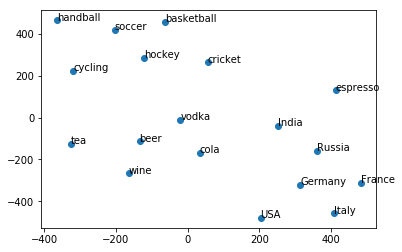

In [16]:
x=tsne[:,0]
y=tsne[:,1]

fig, ax = plt.subplots()
ax.scatter(x, y)

for item, x1, y1 in zip(item_vectors, x, y):
    ax.annotate(item[0], (x1, y1))

plt.show()

**Discussion:** t-SNE is a clever algorithm; you give it a set of points in a high-dimensional space and it iteratively tries to find the best projection onto a lower-dimensional space(usually a plane) that mantains a distance between the points as well as possible. It is therefore very suitable for visualizing higher dimensions like (word) embeddings.  
  
For more complex situations, the *perplexity* parameter is something to play around with. This variable loosely determines the balance between local accuracy and overall accuracy. Setting it to a low value creates small clusters that are locally accurate, setting it highre leads to more local distortions, but with better overall clusters.